price            False
bedrooms          True
bathrooms         True
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool
Anzahl NaN in Bedrooms: 0
Anzahl NaN in Bathrooms: 0


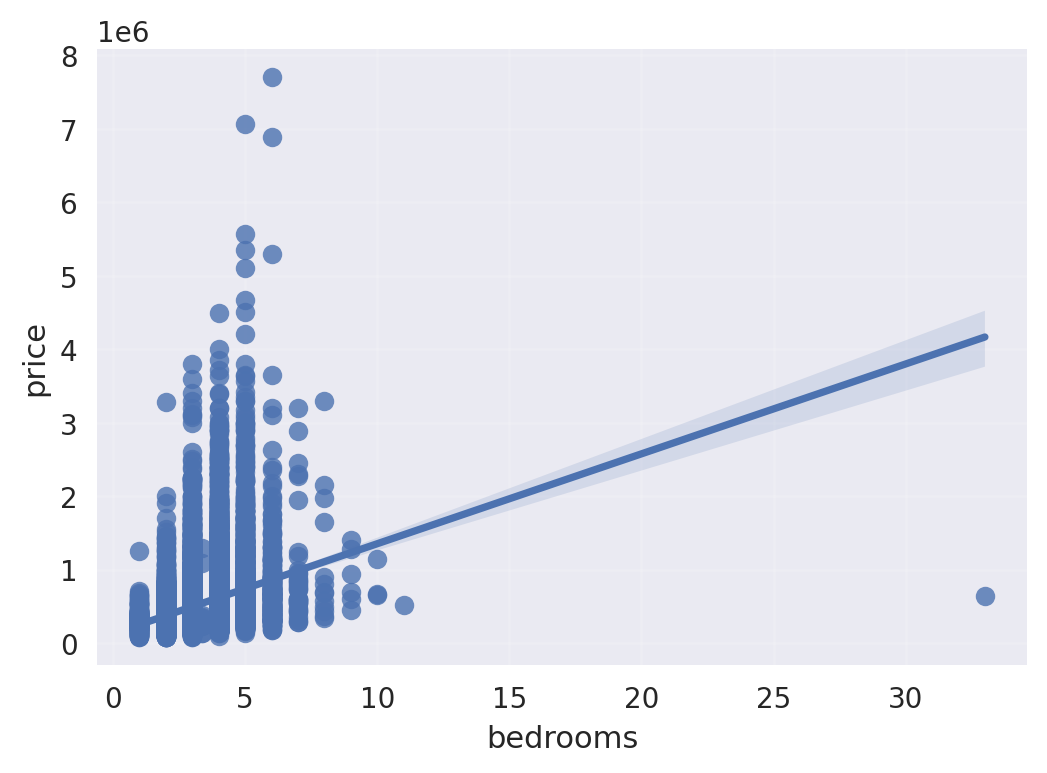

pcoeff: 0.31, pvalue: 0.0


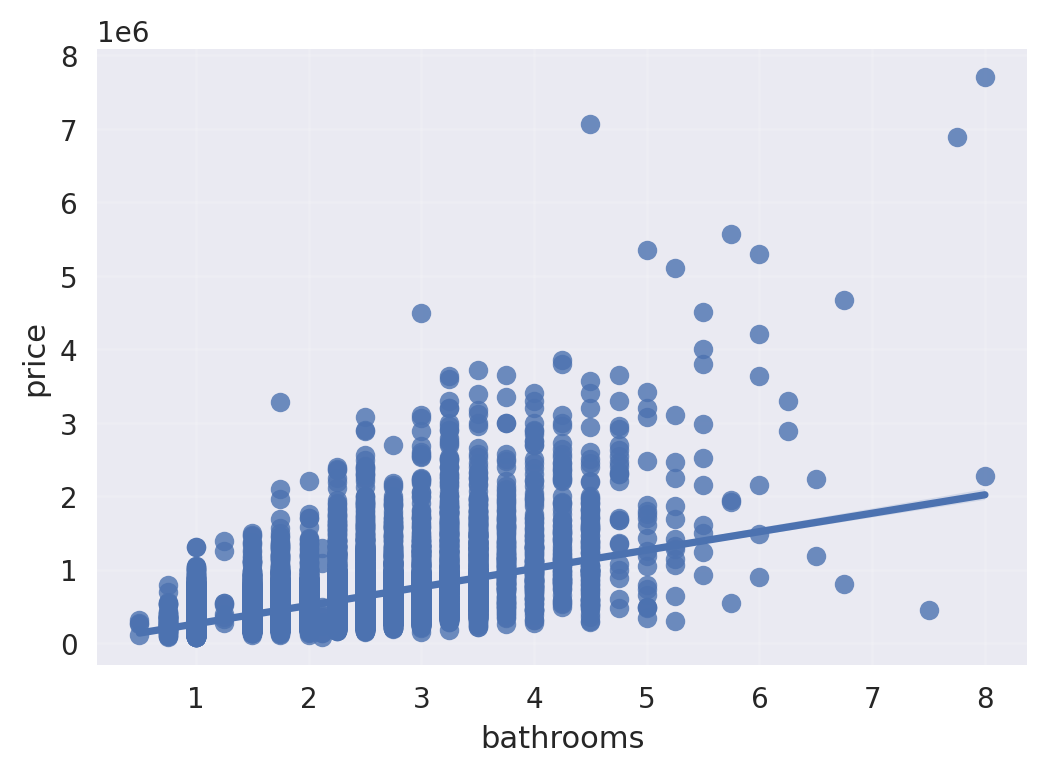

pcoeff: 0.53, pvalue: 0.0


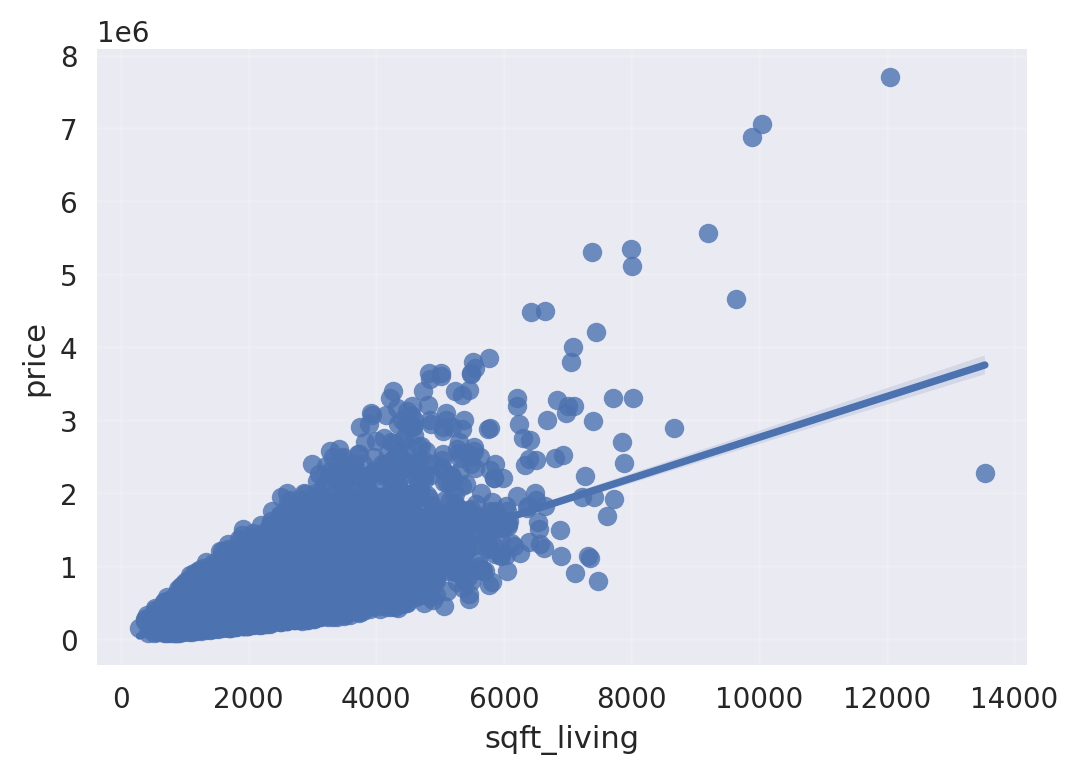

pcoeff: 0.70, pvalue: 0.0


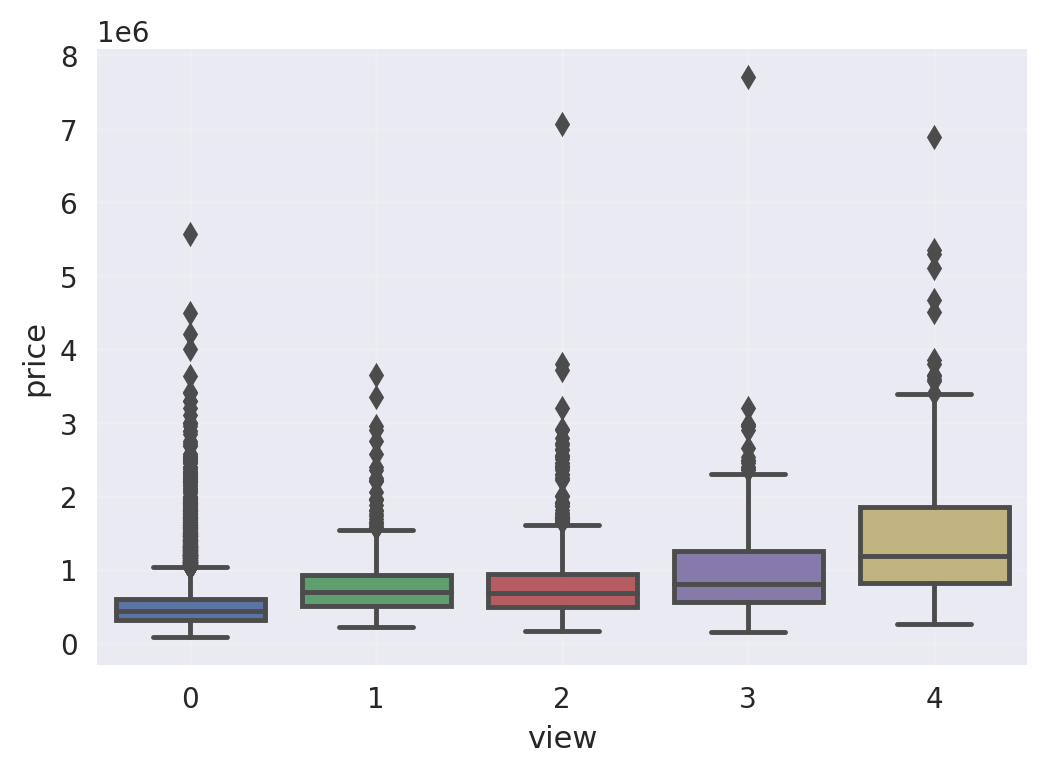

pcoeff: 0.40, pvalue: 0.0


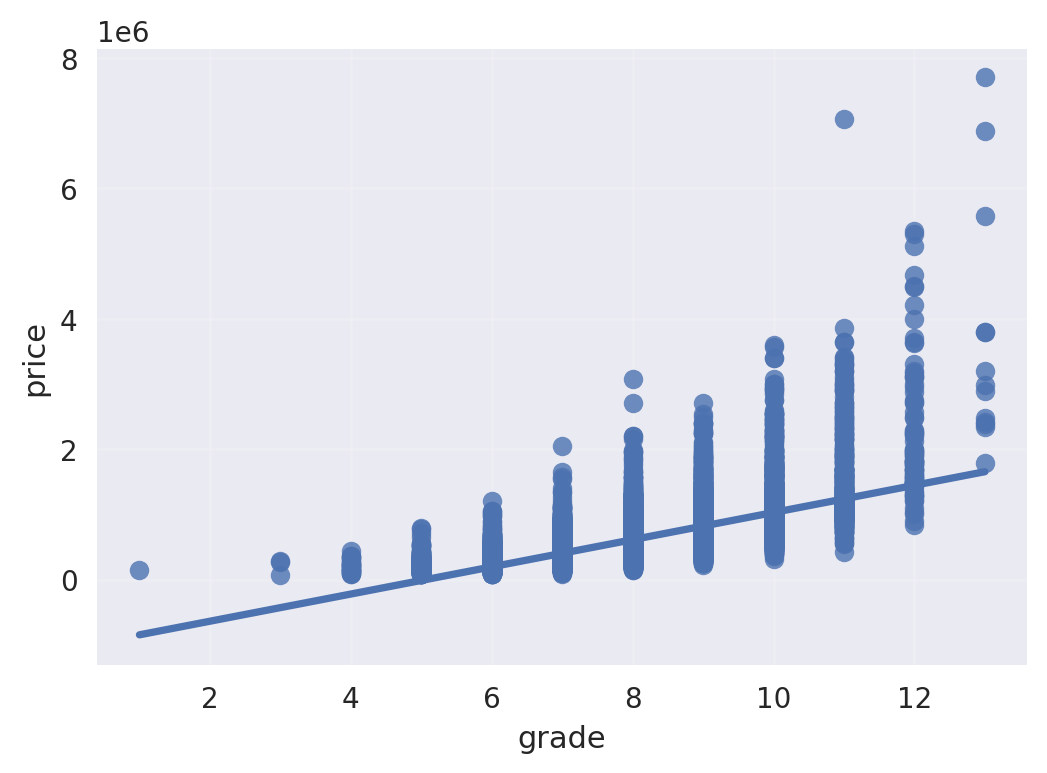

pcoeff: 0.67, pvalue: 0.0


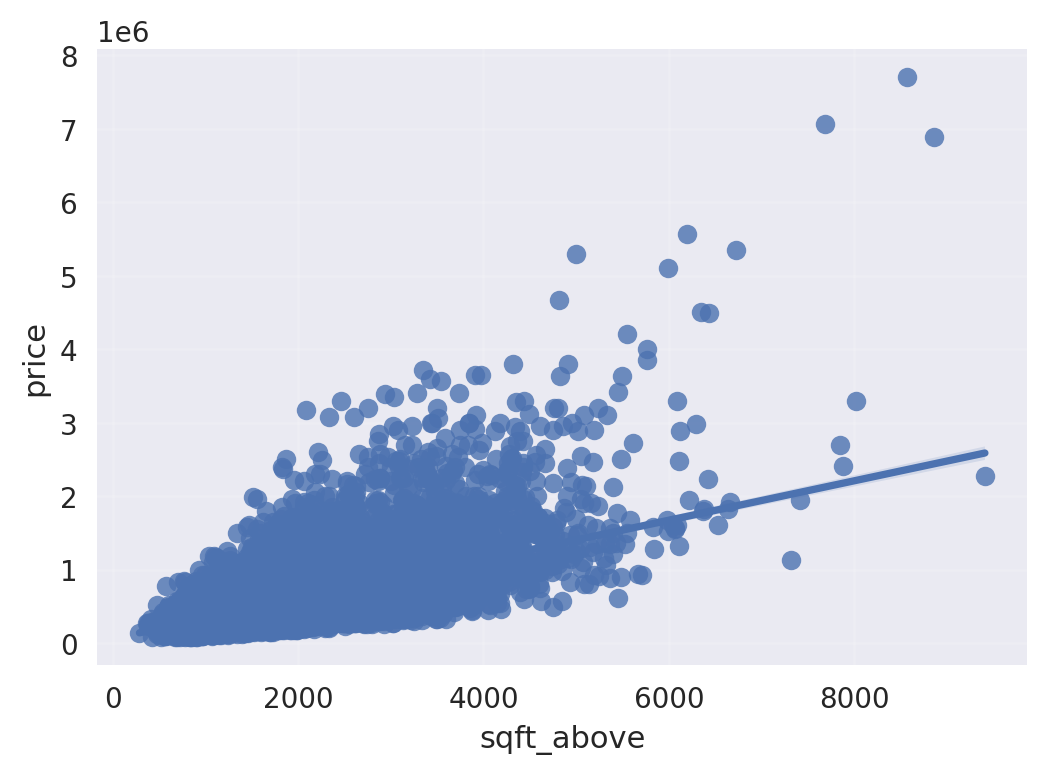

pcoeff: 0.61, pvalue: 0.0


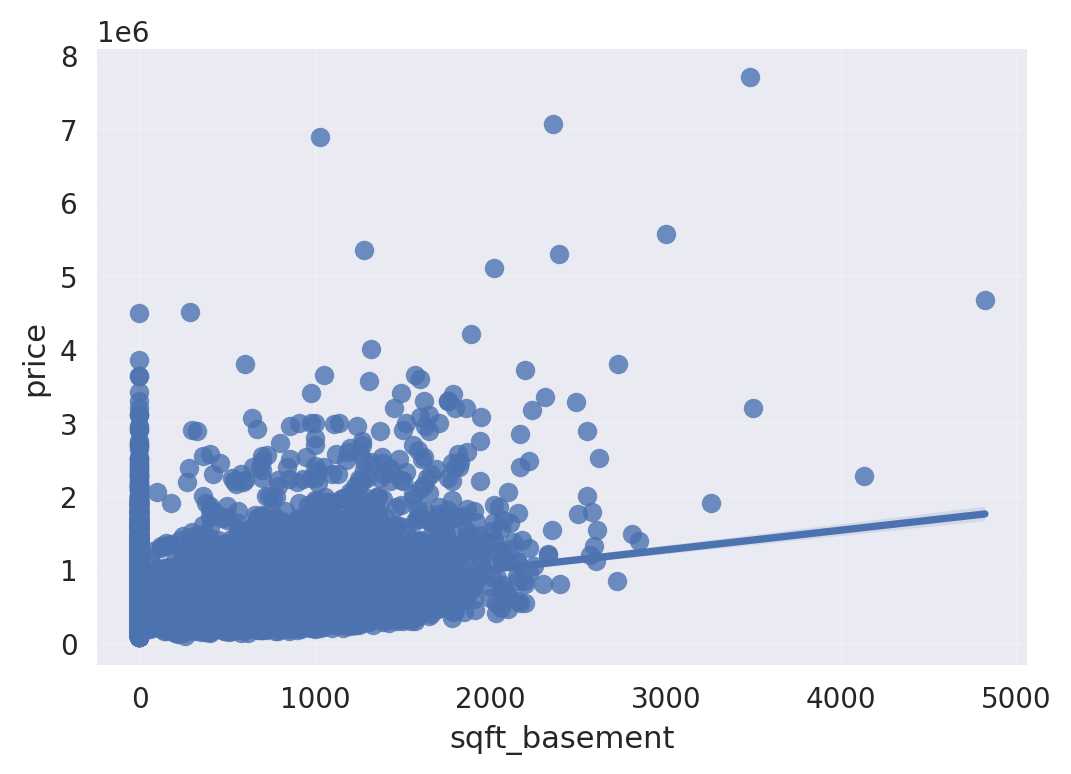

pcoeff: 0.32, pvalue: 0.0


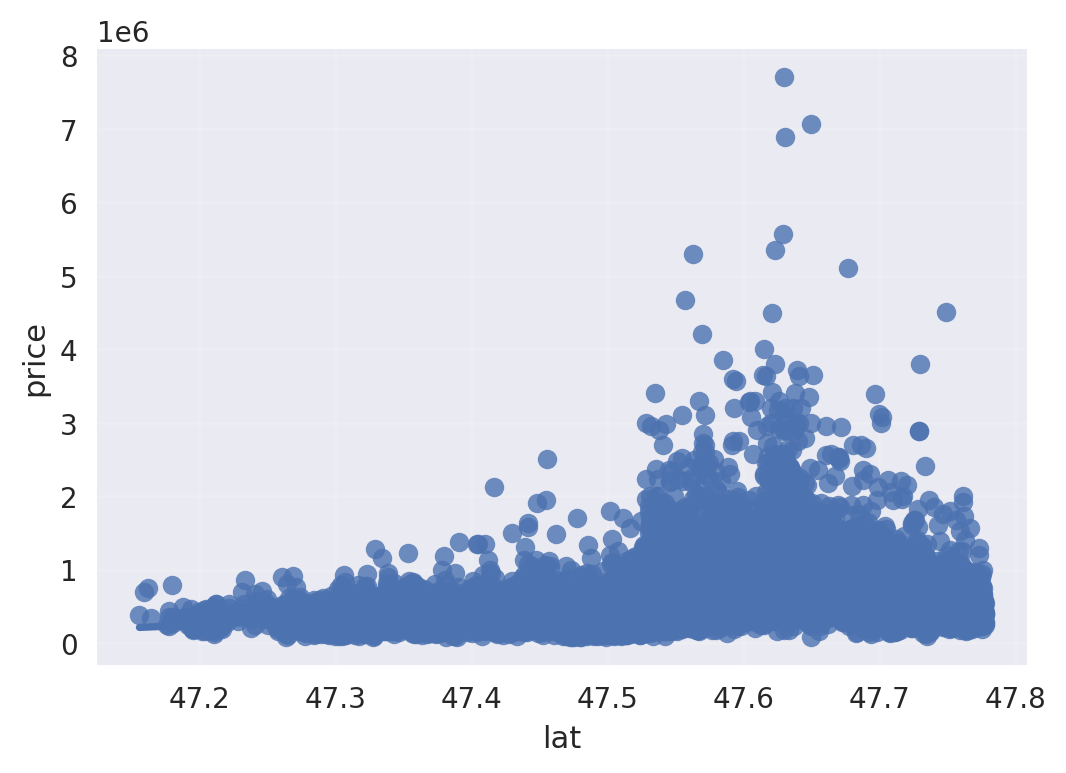

pcoeff: 0.31, pvalue: 0.0


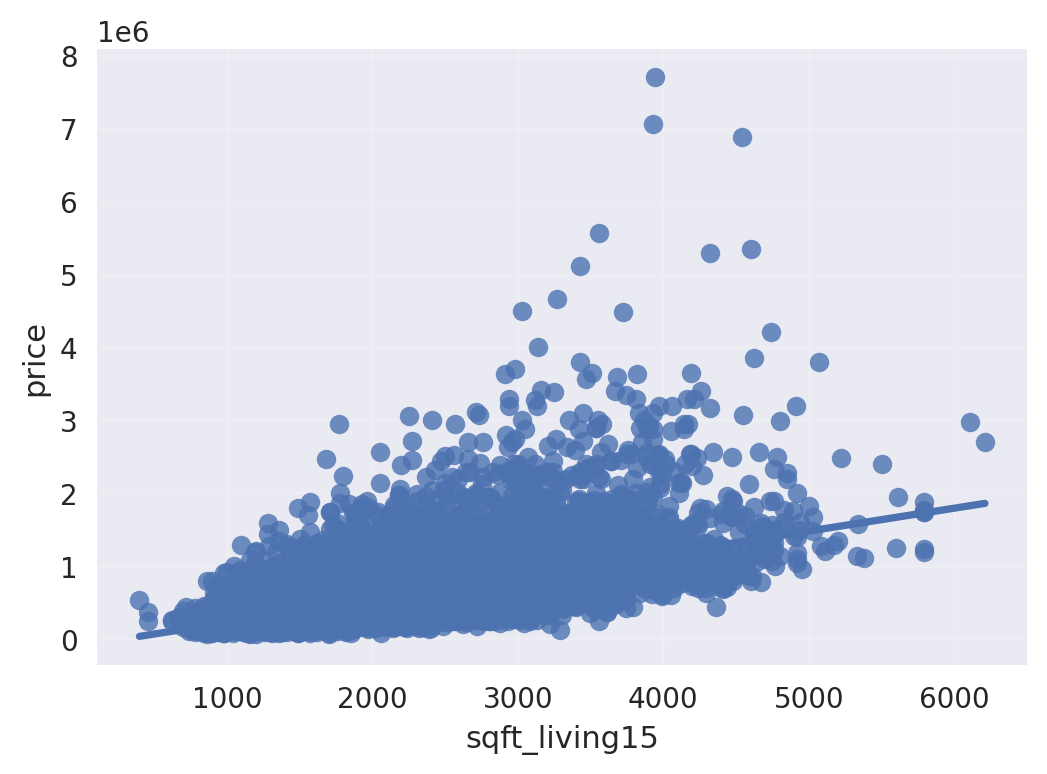

pcoeff: 0.59, pvalue: 0.0


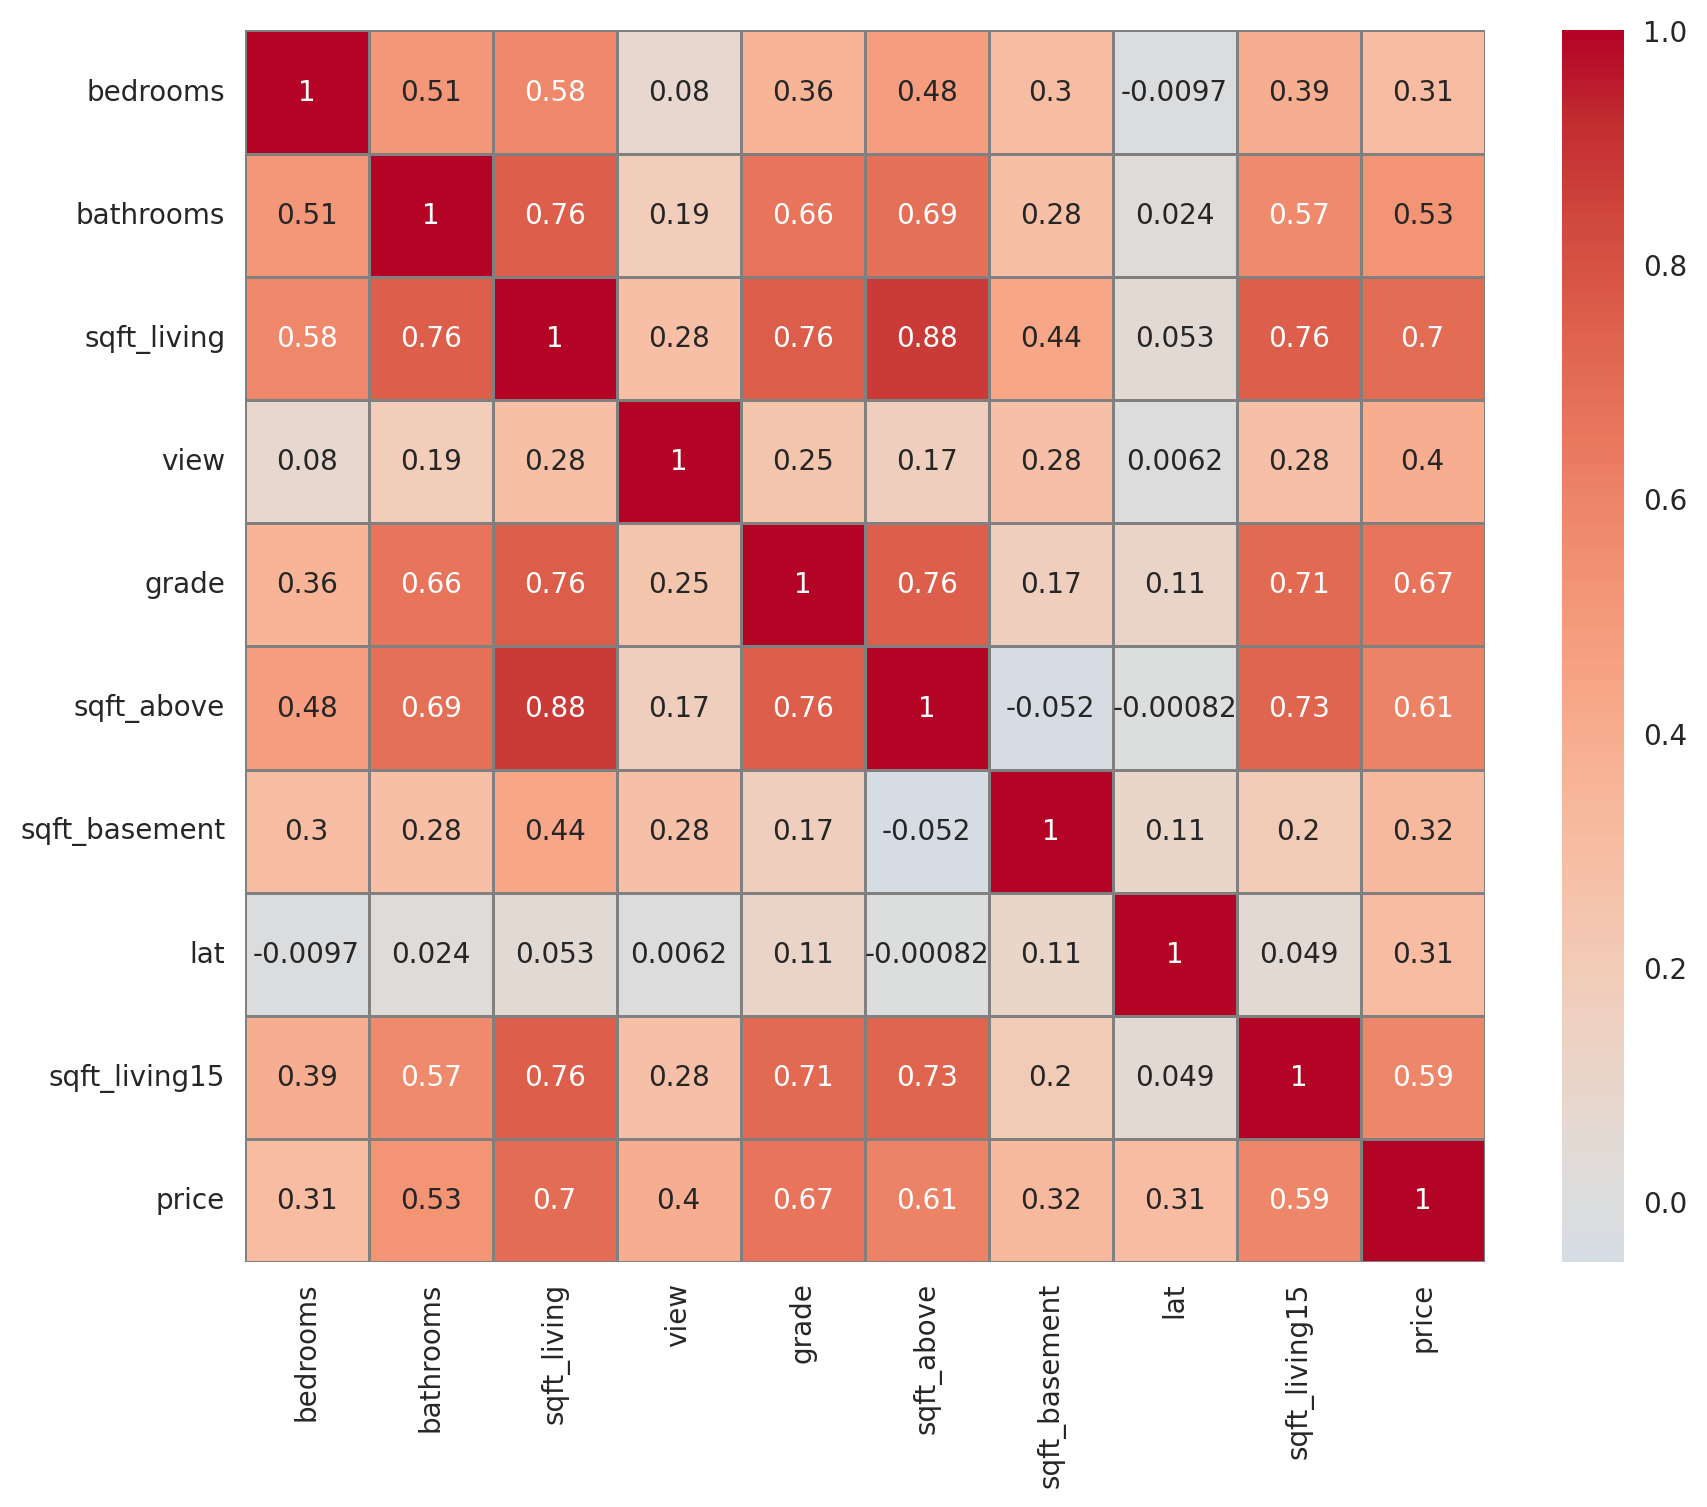

R^2 traindata (lr): 0.64
R^2 testdata (lr): 0.64
R^2 traindata (pr): 0.71
R^2 testdata (pr): 0.72


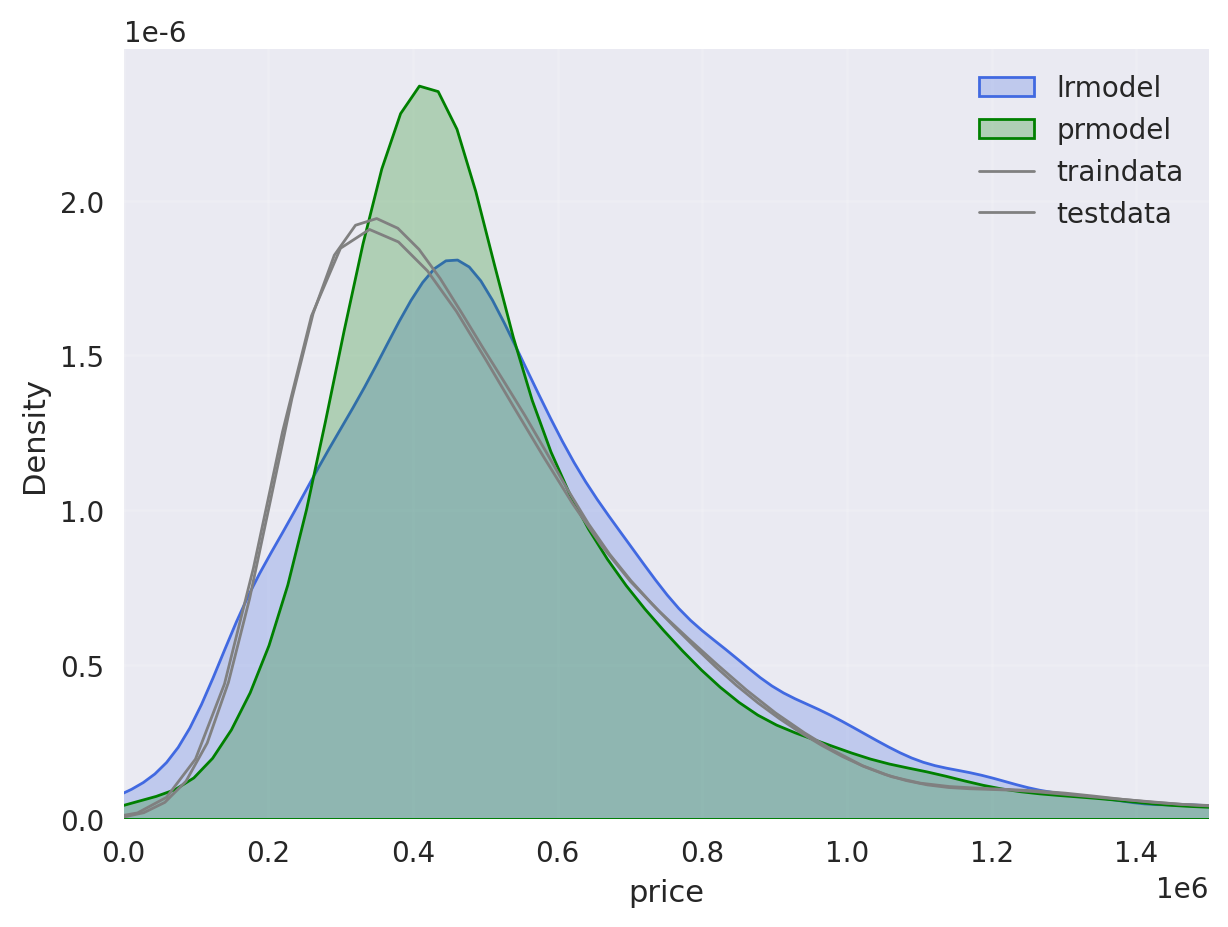

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats

plt.style.use('seaborn')

df = pd.read_csv('house_data.csv')
df.drop(['Unnamed: 0','Unnamed: 1','id','date'],axis=1,inplace=True)
print(df.isna().any()) #handling NaN values
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mean())
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mean())
print('Anzahl NaN in Bedrooms:',df['bedrooms'].isna().sum())
print('Anzahl NaN in Bathrooms:',df['bathrooms'].isna().sum())

numeric_attributes = list(df.select_dtypes(include=['int64','float64']).columns)
numeric_attributes.remove('price')

features = []

for attribute in numeric_attributes:
    pcoeff,pvalue = stats.pearsonr(df[attribute],df['price'])
    if abs(pcoeff) >= 0.3: #feature selection
        features.append(attribute) 
        plt.figure(figsize=(6,4))
        if df[attribute].value_counts().count() <= 10: #categorical features in barplots
            sns.boxplot(x=df[attribute],y=df['price'])
            plt.grid(True,alpha=0.15)
            plt.show()
            print(f'pcoeff: {pcoeff:.2f}, pvalue: {pvalue}')
        else:
            sns.regplot(x=df[attribute],y=df['price'],data=df) 
            plt.grid(True,alpha=0.15)
            plt.show()
            print(f'pcoeff: {pcoeff:.2f}, pvalue: {pvalue}')

features.append('price') #for heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[features].corr(),cmap='coolwarm',annot=True,center=0,cbar=True,linecolor='gray',linewidths=1)
plt.show()
features.remove('price')

x = df[features] #fulldata
y = df['price']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.5,random_state=1)

#first model
lr = LinearRegression()
lr.fit(x_train,y_train)
print(f'R^2 traindata (lr): {cross_val_score(lr,x_train,y_train,cv=10).mean():.2f}')
print(f'R^2 testdata (lr): {lr.score(x_test,y_test):.2f}')

#second model
Input = [('scaler',StandardScaler()),('polynomial',PolynomialFeatures(degree=2)),('ridge',Ridge(alpha=1))]
pipe = Pipeline(Input)
pipe.fit(x_train,y_train)
print(f'R^2 traindata (pr): {cross_val_score(pipe,x_train,y_train,cv=10).mean():.2f}')
print(f'R^2 testdata (pr): {pipe.score(x_test,y_test):.2f}')

#visualizing results
plt.figure(figsize=(7,5))
sns.kdeplot(lr.predict(x_train),color='royalblue',label='lrmodel',linewidth=1,fill=True)
sns.kdeplot(pipe.predict(x_train),color='g',label='prmodel',linewidth=1,fill=True)
sns.kdeplot(y_train,color='gray',label='traindata',linewidth=1)
sns.kdeplot(y_test,color='gray',label='testdata',linewidth=1)
plt.grid(True,alpha=0.15)
plt.xlim(0,1.5e6)
plt.legend()
plt.show()

### Auswertung
Das Polynomial-Regression-Model mit ergänztem Lambda und Feature-Normalization erzielt bei der Preisvorhersage, auf Grundlage verwendeter Attribute, bessere Ergebnisse mit dem Test- und Trainingsdaten.
Beide Modelle decken in etwa $\frac{2}{3}$ bis $\frac{3}{4}$ der Varianz ab und weisen dabei ein gutes Fitting auf Trainings- als auch Testdaten auf. Der gewählte Split liegt hier bei 1:1. Das erklärt auch wieso Trainings-und Testergebnisse fast identisch sind. Der gewählte Filter der Features ist nicht veränderbar ohne die Vorhersageergebnisse negativ zu beeinflussen. Alle Attribute des Datensets spielen eine wichtige Rolle bei der Preisvorhersage und sind von Bedeutung.
Aus den Visualisierungen der einzelnen Attribute, zum Preis, ist erkennbar, dass eine positive Korrelation zum Preis vorliegt und eine Regression der richtige Ansatz ist.